# Google Cloud CMIP6 Public Data

This notebooks shows how to query the catalog, load the data using python, and compute the Emulator Model at the global and grid level

## Section 1: Prepare setup

In [0]:
!pip install --upgrade xarray zarr gcsfs cftime nc-time-axis netCDF4 esgf-pyclient
#!pip install --upgrade xarray zarr gcsfs cftime nc-time-axis #netCDF4 esgf-pyclient

     |████████████████████████████████| 655kB 4.8MB/s 
     |████████████████████████████████| 3.3MB 25.8MB/s 
     |████████████████████████████████| 317kB 46.9MB/s 
     |████████████████████████████████| 4.1MB 8.2MB/s 
     |████████████████████████████████| 3.8MB 38.0MB/s 
  Created wheel for zarr: filename=zarr-2.4.0-cp36-none-any.whl size=127066 sha256=4cd7ceeba39c244933e565fcc0b81dd198eddd63d6dc137ee9b1939b8c2e07ba
  Stored in directory: /root/.cache/pip/wheels/e1/5b/25/24c685604b91139aba00a5b6299b53e7a0661f737f27782559
  Created wheel for esgf-pyclient: filename=esgf_pyclient-0.2.1-cp36-none-any.whl size=28511 sha256=15c345d868ede5b2f4936bbbbff9cbf355ee793afa3e58fed2af1ca04aad4b50
  Stored in directory: /root/.cache/pip/wheels/15/80/bb/959e40259d345fe3518681534d46d14d3a0564ec981eb50612
  Created wheel for asciitree: filename=asciitree-0.3.3-cp36-none-any.whl size=5037 sha256=351379aac641943f1d55db39e7a0fef9f7ca6b1c2a554c82828ac4caf5222065
  Stored in directory: /root/.cache/pip

In [0]:
%%capture
from matplotlib import pyplot as plt
import numpy as np; import pandas as pd
import xarray as xr
import zarr; import gcsfs
#from pyesgf.search import SearchConnection
from sklearn.linear_model import LinearRegression

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


xarray (formerly xray) is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun! Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures.

Zarr is a Python package providing an implementation of chunked, compressed, N-dimensional arrays.

gcfs - A pythonic file-system interface to Google Cloud Storage.

cftime - Time-handling functionality from netcdf4-python

nc-time-axis - Provides support for non-gregorian datetimes in matplotlib based on the cftime package

## Create Functions 
### Calculate Global Mean * Not needed for grid temp modeling

In [0]:
def globalmean( tas, lat ):
    '''
    arguments: tas (average surface temperature), lat (latitude)
    output: numpy array of global annual mean temperature
    '''
    if ( lat[0] == 90 ): endlat = -90
    else: endlat = 90
    latitude = np.linspace( lat[0], endlat, tas.shape[1] + 1 )
    tmean = np.mean(tas, axis=2)
    area = []
    R_earth = 6.3781*10**3 # km
    for i in range(tas.shape[1]): area.append(((3.14159/180)*R_earth**2) * abs(np.sin(latitude[i]*3.14159/180)-np.sin(latitude[i+1]*3.14159/180)) * 360/tas.shape[2])
    totalarea = np.sum(area)
    globaltemp = []
    for k in range( tas.shape[0] ):
        tempyear = []
        for i in range( tas.shape[1]): tempyear.append(tmean[k,i]*area[i]/(totalarea/tas.shape[1]))
        globaltemp.append( np.mean(tempyear) )
    return np.array(globaltemp)

## Browse Catalog

The data catalog is stored as a CSV file. Here we read it with Pandas.

The columns of the dataframe correspond to the CMI6 controlled vocabulary. A beginners' guide to these terms is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q). 

Here we filter the data to find monthly surface air temperature for historical experiments.

In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#here we filter the data to find monthly surface air temperature for historical experiments.

df = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical'")
#Now we do further filtering to find just the models from NCAR.

df_ta_ncar = df.query('institution_id == "NCAR"')
df_ta_ncar

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
38990,CMIP,NCAR,CESM2-FV2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-FV2/historical/r1i1...,NaN
39282,CMIP,NCAR,CESM2-WACCM-FV2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM-FV2/historica...,NaN
40120,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM/historical/r1...,NaN
40395,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM/historical/r2...,NaN
40626,CMIP,NCAR,CESM2-WACCM,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM/historical/r3...,NaN
41659,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r10i1p1f...,NaN
41886,CMIP,NCAR,CESM2,historical,r11i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r11i1p1f...,NaN
42133,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN
42410,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r2i1p1f1...,NaN
42687,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r3i1p1f1...,NaN


## Load Data

Now we will load a single store using gcsfs, zarr, and xarray.

Note: Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all of our cores. We coordinate these blocked algorithms using Dask graphs.

Dask Array is used in fields like atmospheric and oceanographic science, large scale imaging, genomics, numerical algorithms for optimization or statistics, and more.

### Xarray with Dask Arrays

Xarray is an open source project and Python package that extends the labeled data functionality of Pandas to N-dimensional array-like datasets. It shares a similar API to NumPy and Pandas and supports both Dask and NumPy arrays under the hood.

In [0]:
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta_ncar.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  295650.0
    case_id:                23
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.009
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-27T10:42:54Z
    data_specs_version:     01.00.29
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.h...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    grid_label:             gn
    history:                none
    initialization_index:   1
    institution:            National Center for Atmospheric Research, Climate...
    institution_id:         NCAR
    license:                CMIP6 model data produced by <The National Center...
    mip_era:                CMIP6
    model_doi_url:          https://doi.org/10.5065/D67H1H0V
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       CESM2
    parent_time_units:      days since 0001-01-01 00:00:00
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      9
    realm:                  atmos
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    source_id:              CESM2
    source_type:            AOGCM BGC
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/4b164514-1627-4deb-a8d5-93d4c5166d41...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r9i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu

In [0]:
ds.tas.shape

(1980, 192, 288)

Plot a map from a specific month of any year.

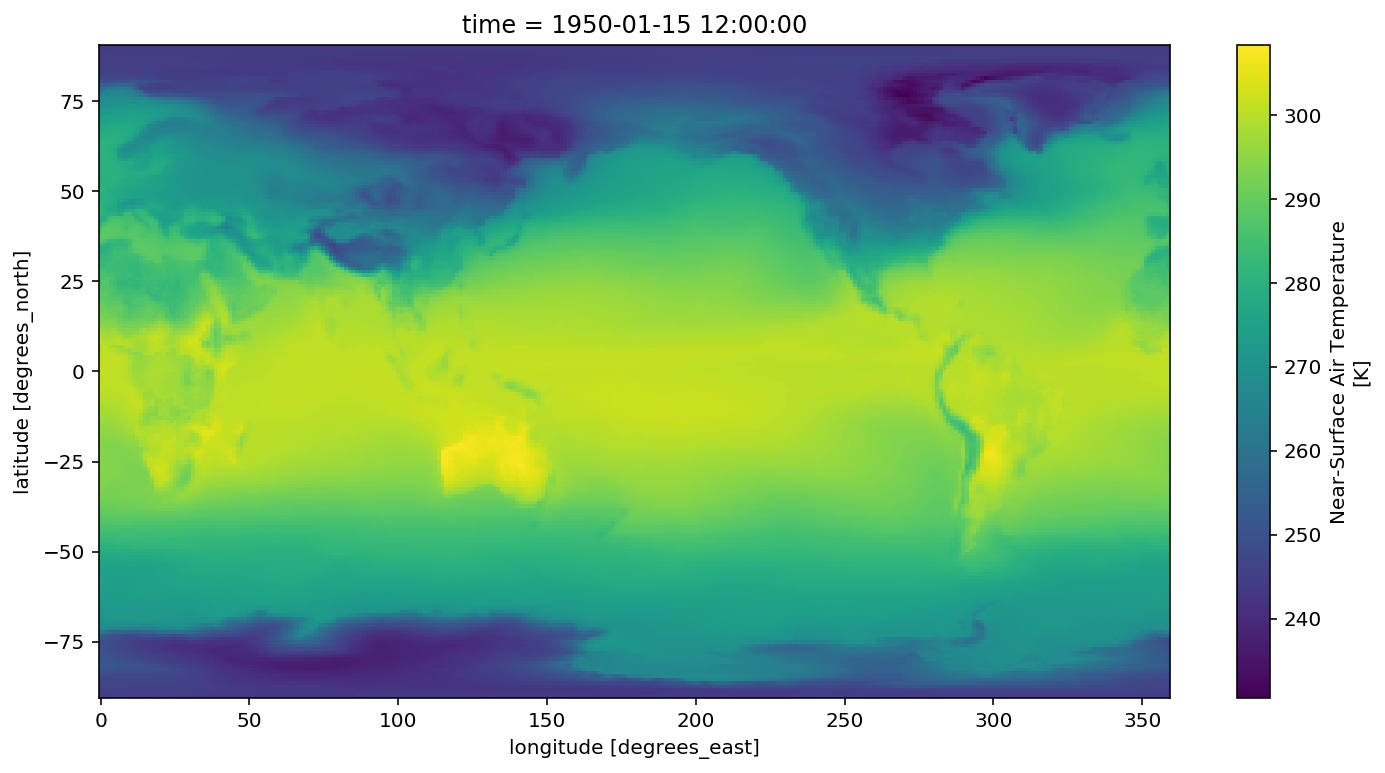

In [0]:
ds.tas.sel(time='1950-01').squeeze().plot()

## Test: Load array of available models that do RCP 8.5

In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_mod = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'ssp585'")
models = df_mod.source_id.unique()
models = list(models)
models

['BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'FGOALS-g3',
 'CanESM5-CanOE',
 'CanESM5',
 'CNRM-CM6-1-HR',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'MPI-ESM1-2-HR',
 'EC-Earth3-Veg',
 'FIO-ESM-2-0',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'UKESM1-0-LL',
 'MRI-ESM2-0',
 'CESM2-WACCM',
 'CESM2',
 'KACE-1-0-G',
 'GFDL-CM4',
 'GFDL-ESM4',
 'MCM-UA-1-0']

### Select any one model

In [0]:
model = 'GFDL-CM4'
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_mod = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & experiment_id == 'ssp585' & source_id == '%s'"%(model))
df_mod

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
234417,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,clivi,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN
234418,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,clt,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN
234419,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,clwvi,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN
234420,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,evspsbl,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN
234421,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,hfls,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN
234422,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,hfss,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN
234423,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,hurs,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN
234424,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,hus,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN
234425,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,huss,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN
234426,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,o3,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp5...,NaN


## Calculate and plot monthly temp

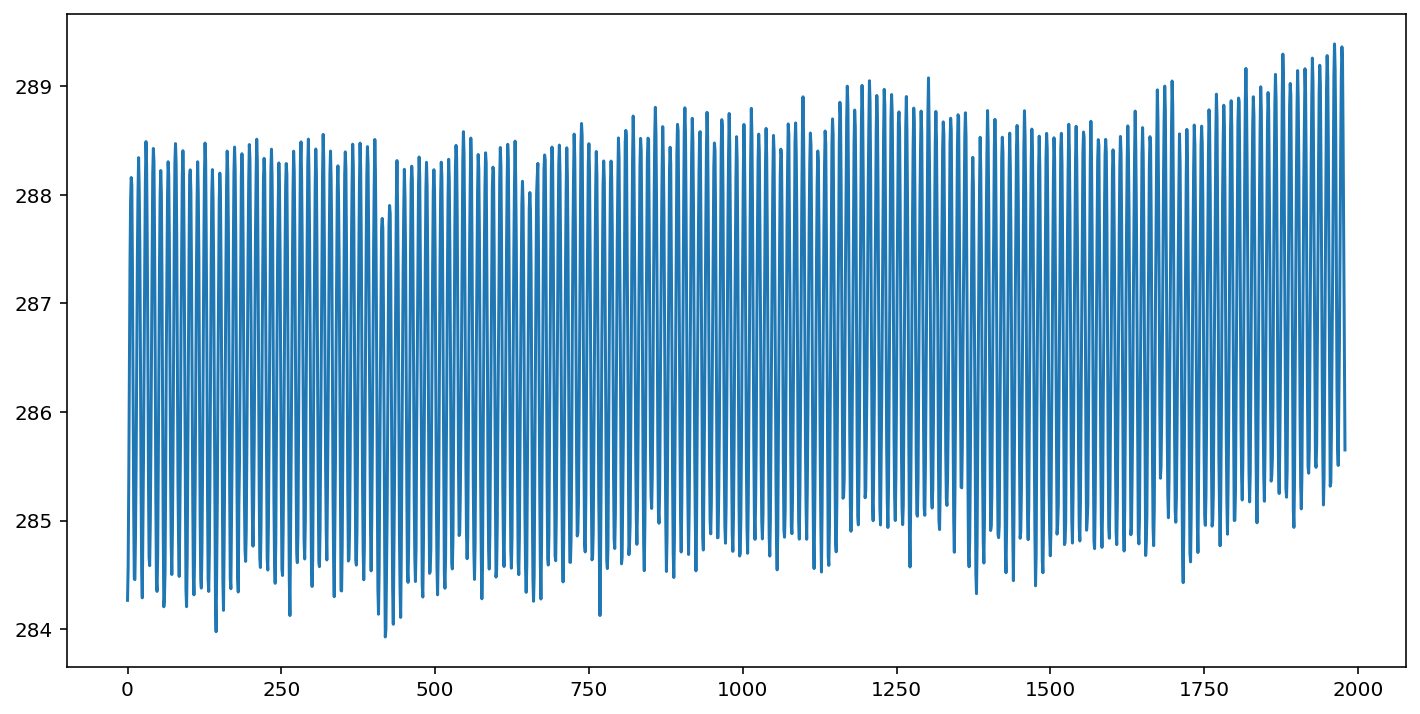

In [0]:
model = 'GFDL-ESM4'
# here we filter the data to find monthly surface air temperature for historical experiments.
df_ta_h = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical' & source_id == '%s'"%(model))
mapper = gcs.get_mapper(df_ta_h.zstore.values[0])
ds_h = xr.open_zarr(mapper, consolidated=True)
tas = ds_h.tas.values
lat = ds_h.lat.values
globalmeantas = globalmean(tas, lat)
plt.plot(globalmeantas)

# Streamlined pipeline for CMIP-6

## Load array of available models that do different SSPs (experiment_id == ssp585/ssp245/ssp126), and for variable_id = tas (average surface temperature)
#### For now, we only focus on variable_id = tas, and not ts

##### Here, we are including only the models which work for global mean.For a detailed list of models which worked for different SSPs, refer to end of the notebook - Model Lists by variable_id 'ts', 'tas', and SSPs

In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

# Example of filtering a specific SSP and variable_id = tas
df_mod = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'ssp126'") # variable_id = tas/ts; experiment_id == ssp585/ssp245/ssp126
models = df_mod.source_id.unique()
models = list(models)
models

## Only list of models that worked for tas and 3 SSPs (ssp126, 245, 585). We use this for the larger global mean temp calculation

In [0]:
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 
          'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 
          'CESM2', 'KACE-1-0-G', 'GFDL-CM4', 'GFDL-ESM4']

## Loop though all models and make a big dataframe of all temperatures (global)

numpy.arange([start, ]stop, [step, ]dtype=None)
Return evenly spaced values within a given interval.

Values are generated within the half-open interval [start, stop) (in other words, the interval including start but excluding stop). For integer arguments the function is equivalent to the Python built-in range function, but returns an ndarray rather than a list.

When using a non-integer step, such as 0.1, the results will often not be consistent. It is better to use numpy.linspace for these cases.



numpy.zeros(shape, dtype=float, order='C')
Return a new array of given shape and type, filled with zeros.

In [0]:
allT = pd.DataFrame({'model': [], 'ssp': [], 'year': [], 'mean_tas': []})
years = np.arange(1850,2100,1).astype(int)
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 
          'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 
          'CESM2', 'KACE-1-0-G', 'GFDL-CM4', 'GFDL-ESM4']

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
for model in models:
    print(model)
    
    # get area of the grids
    #df_area = df.query("variable_id == 'areacella' & source_id == '%s'"%(model))
    #ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)

    # here we filter the data to find monthly surface air temperature for historical experiments.
    df_ta_h = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical' & source_id == '%s'"%(model))
    mapper = gcs.get_mapper(df_ta_h.zstore.values[0])
    ds_h = xr.open_zarr(mapper, consolidated=True)

    # calculate global mean
    #total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
    tas = ds_h.tas.values
    lat = ds_h.lat.values
    #ta_timeseries = (ds_h.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area # globalmean(tas, lat)
    ta_timeseries = globalmean(tas, lat)

    # calculate yearly averages and write to numpy array
    #ta_hist = ta_timeseries.values
    ta_h = np.zeros(165)
    #for i in range(165): ta_h[i] = ta_hist[(i*12):(i*12)+12].mean()
    for i in range(165): ta_h[i] = ta_timeseries[(i*12):(i*12)+12].mean() 
    
    # loop through all ssps (RCPs) for each available model
    df_ssp = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & source_id == '%s'"%(model))
    ssps = df_ssp.experiment_id.unique()
    for ssp in ssps:
        df_fut = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '%s' & source_id == '%s'"%(ssp, model))
        mapper = gcs.get_mapper(df_fut.zstore.values[0])
        ds_fut = xr.open_zarr(mapper, consolidated=True)

        # calculate global mean
        #ta_timeseries = (ds_fut.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
        ta_timeseries = globalmean(tas, lat)

        # calculate yearly averages and write to numpy array
        ta_fut = ta_timeseries
        ta_f = np.zeros(85)
        for i in range(85): ta_f[i] = ta_fut[(i*12):(i*12)+12].mean() 

        ta = np.concatenate((ta_h, ta_f))
        dftemp = pd.DataFrame({'model': model, 'ssp': ssp, 'year': years, 'mean_tas': ta})
        allT = pd.concat((allT,dftemp))

allT.to_csv('/content/drive/Shared drives/GEOS39650/climate_emulator/data/12_CMIP6_models_global_mean_TAS.csv', sep=',', index=False)

CESM2
CESM2-WACCM
CNRM-CM6-1
CNRM-ESM2-1
CanESM5
GFDL-CM4
GFDL-ESM4
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MRI-ESM2-0


# GRID LEVEL DATA

In [0]:
# Explore model = CanESM5, and SSP585
model = 'CanESM5'
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_ta_h = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'ssp585' & source_id == '%s'"%(model))
df_ta_h

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
215534,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
215654,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
215750,ScenarioMIP,CCCma,CanESM5,ssp585,r11i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
215808,ScenarioMIP,CCCma,CanESM5,ssp585,r11i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
215867,ScenarioMIP,CCCma,CanESM5,ssp585,r12i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
215925,ScenarioMIP,CCCma,CanESM5,ssp585,r12i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
215984,ScenarioMIP,CCCma,CanESM5,ssp585,r13i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
216042,ScenarioMIP,CCCma,CanESM5,ssp585,r13i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
216101,ScenarioMIP,CCCma,CanESM5,ssp585,r14i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN
216159,ScenarioMIP,CCCma,CanESM5,ssp585,r14i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN


In [0]:
mapper = gcs.get_mapper(df_ta_h.zstore.values[0])
ds_h = xr.open_zarr(mapper, consolidated=True)
#ds_h
ds_h.tas.shape

(1032, 64, 128)

In [0]:
ta_timeseries = ds_h.tas
ta_yearly = ta_timeseries.resample(time='1Y').mean()
ta_yearly.load

<bound method DataArray.load of <xarray.DataArray 'tas' (time: 86, lat: 64, lon: 128)>
dask.array<stack, shape=(86, 64, 128), dtype=float32, chunksize=(1, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-12-31 00:00:00 ... 2100-12-31 00:00:00
    height   float64 2.0
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2>

In [0]:
#xr.DataArray.to_netcdf(self, ds_h, '/content/drive/Shared drives/GEOS39650/climate_emulator/data/grid_tas_data/CanESM5_SSP585_tas.nc4',  format = 'NETCDF4')
ds_h.to_netcdf(path = '/content/drive/Shared drives/GEOS39650/climate_emulator/data/grid_tas_data/CanESM5_SSP585_tas.nc4')

## Gather all grid data and save as netcdf

## First get list of models 

In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# Get list of models for different SSPs and variable_id = tas
df_mod = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'ssp370'") # variable_id = tas; experiment_id == ssp585/ssp245/ssp126/aap119/ssp370
models = df_mod.source_id.unique()
models = list(models)
models

['BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'FGOALS-g3',
 'CanESM5-CanOE',
 'CanESM5',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'MPI-ESM1-2-HR',
 'EC-Earth3-Veg',
 'EC-Earth3',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'UKESM1-0-LL',
 'MRI-ESM2-0',
 'CESM2-WACCM',
 'CESM2',
 'GFDL-ESM4',
 'MCM-UA-1-0']

## Commented out below chunk of codes since grid level data already generated and is in the drive folder GEOS39650/climate_emulator/data/grid_tas_data/model_ssp_tas.nc4'

## Historical Data

In [0]:
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 
          'MPI-ESM1-2-HR', 'EC-Earth3', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 
          'CESM2', 'KACE-1-0-G', 'GFDL-CM4', 'GFDL-ESM4']

          #'INM-CM5-0', 'MCM-UA-1-0' don't work

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

for model in models:
  print (model)
  df_ta_h = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical' & source_id == '%s'"%(model))
  mapper = gcs.get_mapper(df_ta_h.zstore.values[0])
  ds_h = xr.open_zarr(mapper, consolidated=True)
  ds_h.to_netcdf(path = '/content/drive/Shared drives/GEOS39650/climate_emulator/data/grid_tas_data/Historical/01Historical_%s_tas.nc4'%(model))
  

BCC-CSM2-MR
CAMS-CSM1-0
FGOALS-g3
CanESM5-CanOE
CanESM5
CNRM-CM6-1
CNRM-ESM2-1
ACCESS-CM2
ACCESS-ESM1-5
MPI-ESM1-2-HR
EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
UKESM1-0-LL
MRI-ESM2-0
CESM2-WACCM
CESM2
KACE-1-0-G
GFDL-CM4
GFDL-ESM4


## Scenario Data

In [0]:
'''
# For ssp 126, 245, 585
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 
          'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 
          'CESM2', 'GFDL-ESM4']
                                                          # KACE-1-0-G - ssp126 worked, ssp245 did not work, ssp585 worked. Error message: index 0 is out of bounds for axis 0 with size 0
                                                          # GFDL-CM4 ssp126 did not work;ssp245 and ssp585 worked 
                                                          # Run 'KACE-1-0-G', 'GFDL-CM4' separatly for respective ssps available
ssps = ['ssp126', 'ssp245', 'ssp585']
'''


'''
# For ssp 119
models = ['CAMS-CSM1-0', 'CanESM5', 'CNRM-ESM2-1', 'EC-Earth3-Veg', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'GFDL-ESM4']
ssps = ['ssp119']
'''

'''
# For ssp 370
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2',  'ACCESS-ESM1-5', 'MPI-ESM1-2-HR',
          'EC-Earth3-Veg', 'EC-Earth3', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'GFDL-ESM4', 'MCM-UA-1-0']
                                                          # MCM-UA-1-0 spits error - Variable 'height' has conflicting _FillValue (nan) and missing_value (1.0000000200408773e+20). Cannot encode data.
ssps = ['ssp370']
'''

'''
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

for model in models:
  for ssp in ssps:
    print (model, ssp)
    df_ta_h = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '%s' & source_id == '%s'"%(ssp, model))
    mapper = gcs.get_mapper(df_ta_h.zstore.values[0])
    ds_h = xr.open_zarr(mapper, consolidated=True)
    ds_h.to_netcdf(path = '/content/drive/Shared drives/GEOS39650/climate_emulator/data/grid_tas_data/%s_%s_tas.nc4'%(model, ssp))
 ''' 

BCC-CSM2-MR ssp370
CAMS-CSM1-0 ssp370
FGOALS-g3 ssp370
CanESM5-CanOE ssp370
CanESM5 ssp370
CNRM-CM6-1 ssp370
CNRM-ESM2-1 ssp370
ACCESS-CM2 ssp370
ACCESS-ESM1-5 ssp370
MPI-ESM1-2-HR ssp370
EC-Earth3-Veg ssp370
EC-Earth3 ssp370
INM-CM5-0 ssp370
IPSL-CM6A-LR ssp370
MIROC-ES2L ssp370
MIROC6 ssp370
UKESM1-0-LL ssp370
MRI-ESM2-0 ssp370
CESM2-WACCM ssp370
CESM2 ssp370
GFDL-ESM4 ssp370
MCM-UA-1-0 ssp370


ValueError: ignored

(array([9.90000e+01, 1.33900e+03, 2.15180e+04, 2.19380e+04, 3.21790e+04,
        6.81230e+04, 1.50217e+05, 1.41355e+05, 2.36863e+05, 3.08810e+04]),
 array([198.76338, 210.59378, 222.42416, 234.25456, 246.08496, 257.91534,
        269.74576, 281.57614, 293.40652, 305.23694, 317.06732],
       dtype=float32),
 <a list of 10 Patch objects>)

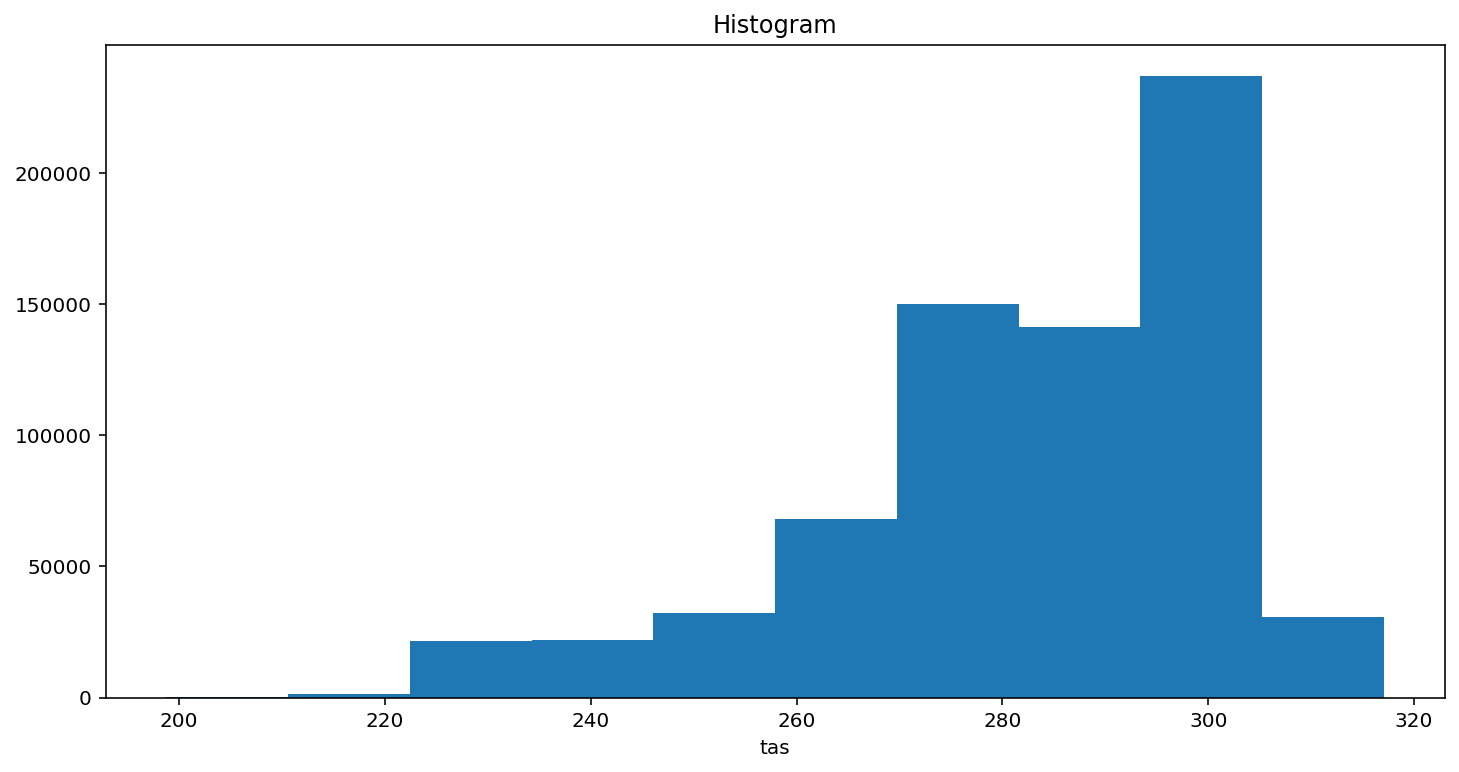

In [0]:
ta_yearly.plot(label = 'annual mean')

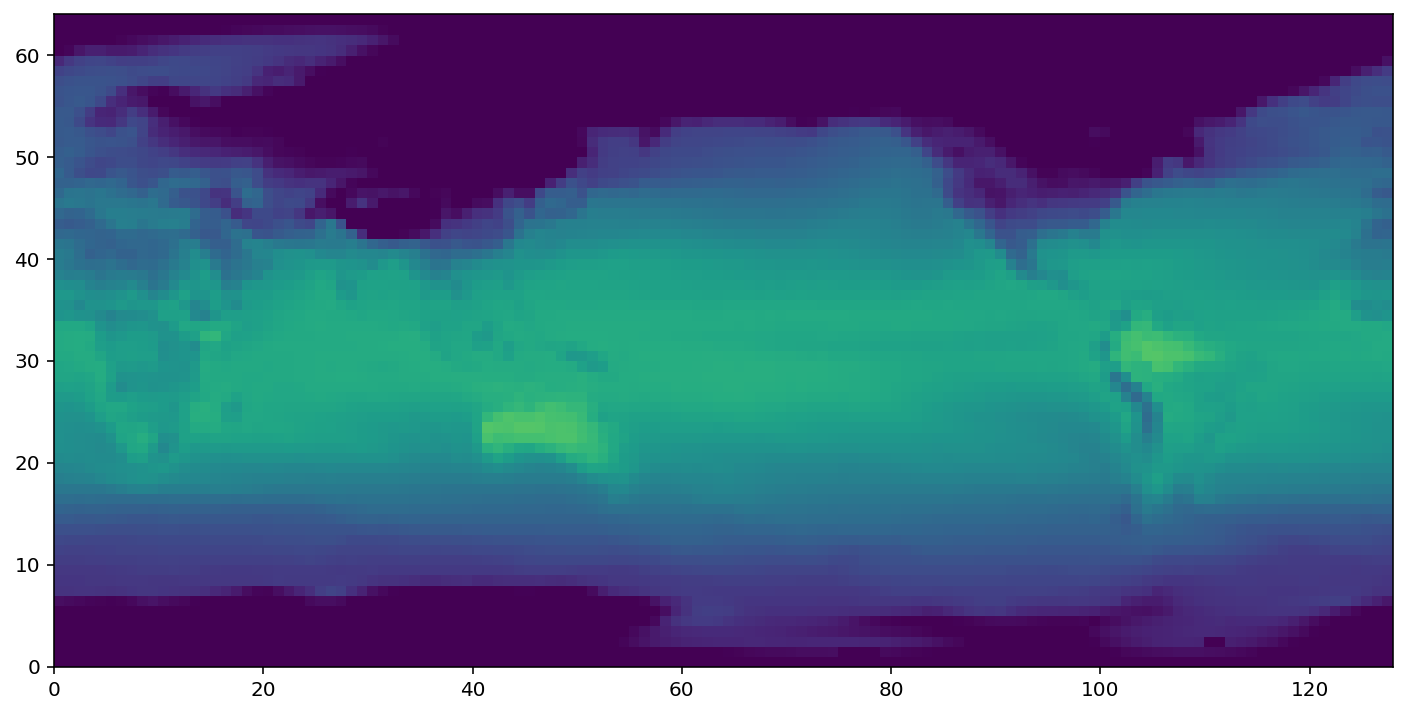

In [0]:
#ta_timeseries.plot(label='12 month rolling mean')
#plt.legend()
#plt.title('Global Mean Surface Air Temperature')

plt.pcolormesh(ta_timeseries[0,:,:], vmin = 260, vmax = 330)

# Regression

# Preparing our X
Below CO2 numbers have been updated from RCP_USETHISONE.xls file

In [0]:
co2_cmip6 = np.array([[287.78, 289.916, 291.898, 295.77, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.17, 351.328, 371.945, 395.324, 415.858, 454.5886302, 500.4540237, 528.1148625, 516.9367551, 496.0068019, 475.5664733, 462.1211541, 451.8190072, 442.7498305, 433.143816], 
                [287.78, 289.916, 291.898, 295.77, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.17, 351.328, 371.945, 395.324, 415.858, 453.7140479, 490.1322126, 525.6623697, 532.97198, 528.7307179, 520.4791547, 511.7900731, 500.8750467, 488.0729028, 478.788738], 
                [287.78, 289.916, 291.898, 295.77, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.17, 351.328, 371.945, 395.324, 415.858, 454.1836676, 503.644716, 534.2957085, 565.4677781, 584.5098883, 599.4000754, 613.7304992, 625.6137785, 632.5225028, 633.142493], 
                [287.78, 289.916, 291.898, 295.77, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.17, 351.328, 371.945, 395.324, 415.858, 453.010787, 497.0504263, 548.6440394, 602.19642, 651.7839106, 708.1686295, 771.123235, 841.5055366, 921.881719, 1013.049655], 
                [287.78, 289.916, 291.898, 295.77, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.17, 351.328, 371.945, 395.324, 415.858, 454.2720586, 515.5437705, 574.45281, 641.5173906, 719.2341047, 806.4558356, 911.9594799, 1033.949852, 1163.013162, 1292.701399]]).transpose()
x = np.array(pd.DataFrame(co2, columns=['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585'], index=np.linspace(1850, 2100, 26)).reindex(np.linspace(1850, 2100, 251)).interpolate(method='cubic'))

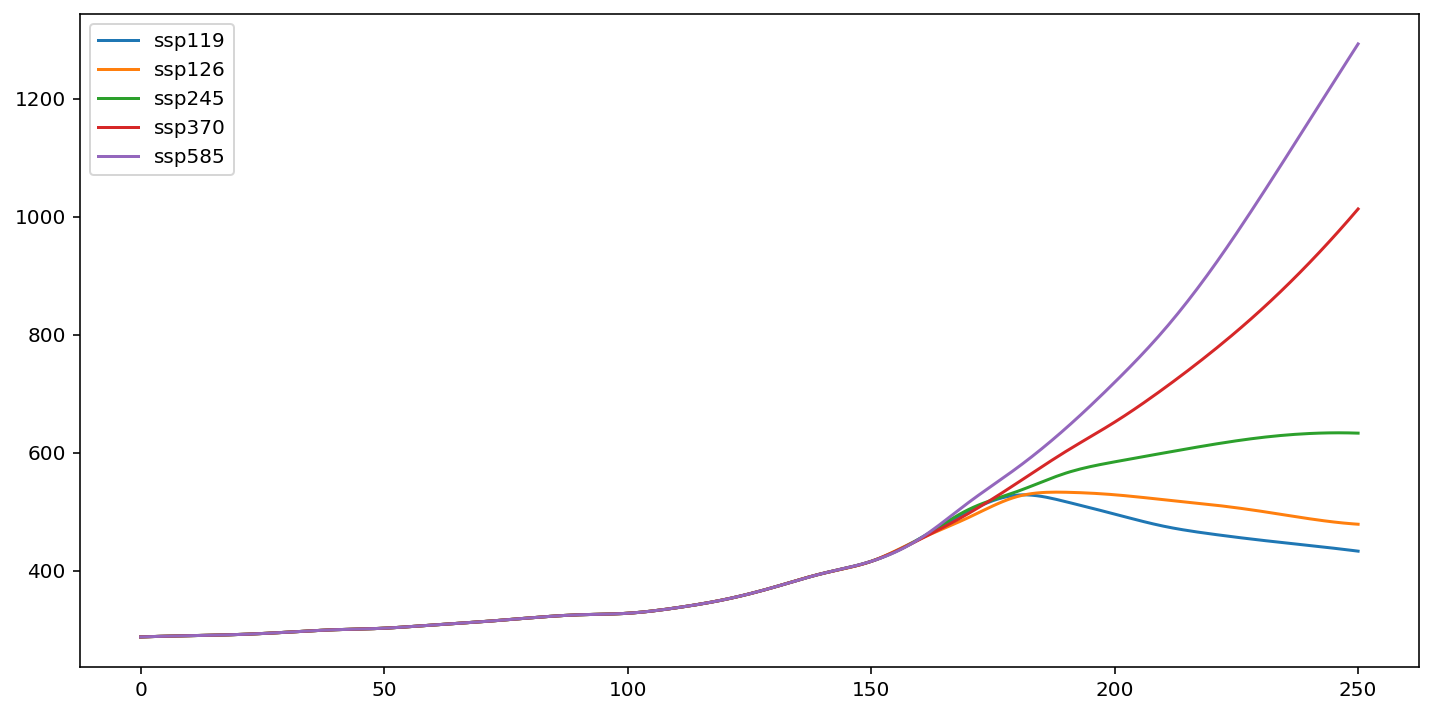

In [0]:
plt.plot(x)
plt.legend(['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585'])

## Convert CO2e np array to long format

In [0]:
df_x = pd.DataFrame(x, columns=['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585'], index=np.linspace(1850, 2100, 251))
print(df_x)

            ssp119      ssp126      ssp245       ssp370       ssp585
1850.0  287.780000  287.780000  287.780000   287.780000   287.780000
1851.0  288.078858  288.078858  288.078858   288.078858   288.078858
1852.0  288.351441  288.351441  288.351441   288.351441   288.351441
1853.0  288.600497  288.600497  288.600497   288.600497   288.600497
1854.0  288.828775  288.828775  288.828775   288.828775   288.828775
...            ...         ...         ...          ...          ...
2096.0  437.184751  481.664587  633.711888   975.268210  1241.094074
2097.0  436.206668  480.818166  633.675144   984.548234  1254.048157
2098.0  435.208548  480.052388  633.568651   993.938282  1266.970978
2099.0  434.188295  479.373747  633.391427  1003.438656  1279.857178
2100.0  433.143816  478.788738  633.142493  1013.049655  1292.701399

[251 rows x 5 columns]


In [0]:
df_x.reset_index()

,index,ssp119,ssp126,ssp245,ssp370,ssp585
0,1850.0,287.780000,287.780000,287.780000,287.780000,287.780000
1,1851.0,288.078858,288.078858,288.078858,288.078858,288.078858
2,1852.0,288.351441,288.351441,288.351441,288.351441,288.351441
3,1853.0,288.600497,288.600497,288.600497,288.600497,288.600497
4,1854.0,288.828775,288.828775,288.828775,288.828775,288.828775
...,...,...,...,...,...,...
246,2096.0,437.184751,481.664587,633.711888,975.268210,1241.094074
247,2097.0,436.206668,480.818166,633.675144,984.548234,1254.048157
248,2098.0,435.208548,480.052388,633.568651,993.938282,1266.970978
249,2099.0,434.188295,479.373747,633.391427,1003.438656,1279.857178


In [0]:
df_xlong = df_x.unstack().reset_index() 
print(df_xlong.head(10)) 

  level_0  level_1           0
0  ssp119   1850.0  287.780000
1  ssp119   1851.0  288.078858
2  ssp119   1852.0  288.351441
3  ssp119   1853.0  288.600497
4  ssp119   1854.0  288.828775
5  ssp119   1855.0  289.039022
6  ssp119   1856.0  289.233988
7  ssp119   1857.0  289.416420
8  ssp119   1858.0  289.589067
9  ssp119   1859.0  289.754678


In [0]:
df_xlong.columns = ['ssp','year','CO2e']
df_xlong['year'] = df_xlong['year'].astype(int)
df_xlong.to_csv('/content/drive/Shared drives/GEOS39650/climate_emulator/data/20200309_CMIP6_CO2e_allSSPs.csv', sep=',', index=False)

In [0]:
df_temp = pd.read_csv('/content/drive/Shared drives/GEOS39650/climate_emulator/data/12_CMIP6_models_global_mean.csv', sep=',')
df_merged = pd.merge(df_xlong, df_temp, on=['year', 'ssp'], how='outer')
print(df_merged)

In [0]:
df_merged.to_csv('/content/drive/Shared drives/GEOS39650/climate_emulator/data/20200309_12_CMIP6_models_temperature_CO2e_merged.csv', sep=',', index=False)

In [0]:
# OLD CO2e data for ssps equivalent to 'RCP60', 'RCP45', 'RCP26', 'RCP85'
'''
co2 = np.array([[287.78, 289.916, 291.898, 295.77, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.17, 351.328, 371.945, 395.324, 415.858, 442.38, 469.324, 494.974, 524.967, 562.025, 606.679, 658.827, 715.961, 764.288, 799.868],
                [287.780, 289.916, 291.898, 295.770, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.170, 351.328, 371.945, 395.324, 415.858, 442.353, 471.958, 503.799, 537.235, 569.715, 596.993, 614.770, 621.480, 623.855, 629.592],
                [287.780, 289.916, 291.898, 295.770, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.170, 351.328, 371.945, 395.324, 415.858, 442.761, 470.821, 490.699, 501.433, 503.321, 499.944, 494.224, 487.717, 481.394, 475.193],
                [287.780, 289.916, 291.898, 295.770, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.170, 351.328, 371.945, 395.324, 415.858, 443.065, 482.759, 534.353, 599.343, 683.062, 785.604, 902.529, 1029.936, 1167.748, 1313.451]]).transpose()
x = np.array(pd.DataFrame(co2, columns=['RCP60', 'RCP45', 'RCP26', 'RCP85'], index=np.linspace(1850, 2100, 26)).reindex(np.linspace(1850, 2100, 251)).interpolate(method='cubic'))
plt.plot(x)
x.shape
'''

"\nco2 = np.array([[287.78, 289.916, 291.898, 295.77, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.17, 351.328, 371.945, 395.324, 415.858, 442.38, 469.324, 494.974, 524.967, 562.025, 606.679, 658.827, 715.961, 764.288, 799.868],\n                [287.780, 289.916, 291.898, 295.770, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.170, 351.328, 371.945, 395.324, 415.858, 442.353, 471.958, 503.799, 537.235, 569.715, 596.993, 614.770, 621.480, 623.855, 629.592],\n                [287.780, 289.916, 291.898, 295.770, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.170, 351.328, 371.945, 395.324, 415.858, 442.761, 470.821, 490.699, 501.433, 503.321, 499.944, 494.224, 487.717, 481.394, 475.193],\n                [287.780, 289.916, 291.898, 295.770, 300.064, 302.579, 308.156, 313.601, 320.124, 325.322, 327.921, 337.170, 351.328, 371.945, 395.324, 415.858, 443.065, 482.759, 534.353, 599.343, 683.062, 785.604, 902.529, 1029.936, 1167.748

(251, 4)

# check log summation function to calculate past CO2 trajectory


In [0]:
'''
#Experiment - when using only for one dimensional array
xnew = np.zeros_like(x)
rho = 0.8 #test differnt rows
for i in range(x.shape[0]):
  ks = np.flip(np.arange(0,i))
  rhoa = rho ** ks 
  #print(rhoa.sum())
  xnew[i] = (1- rho) * np.sum(rhoa*(np.log((x[0:i])/287.780))) # check this ????
'''

'\n#Experiment - when using only for one dimensional array\nxnew = np.zeros_like(x)\nrho = 0.8 #test differnt rows\nfor i in range(x.shape[0]):\n  ks = np.flip(np.arange(0,i))\n  rhoa = rho ** ks \n  #print(rhoa.sum())\n  xnew[i] = (1- rho) * np.sum(rhoa*(np.log((x[0:i])/287.780))) # check this ????\n'

In [0]:
#Experiment -  when using >1D array

xnew = np.zeros_like(x)
rho = 0.8 # Test for different rho's
for j in range(x.shape[1]):
  for i in range(x.shape[0]):
    ks = np.flip(np.arange(0,i))
    rhoa = rho ** ks 
    #print(rhoa.sum())
    xnew[i,j] = (1- rho) * np.sum(rhoa*(np.log((x[0:i,j])/287.780)))


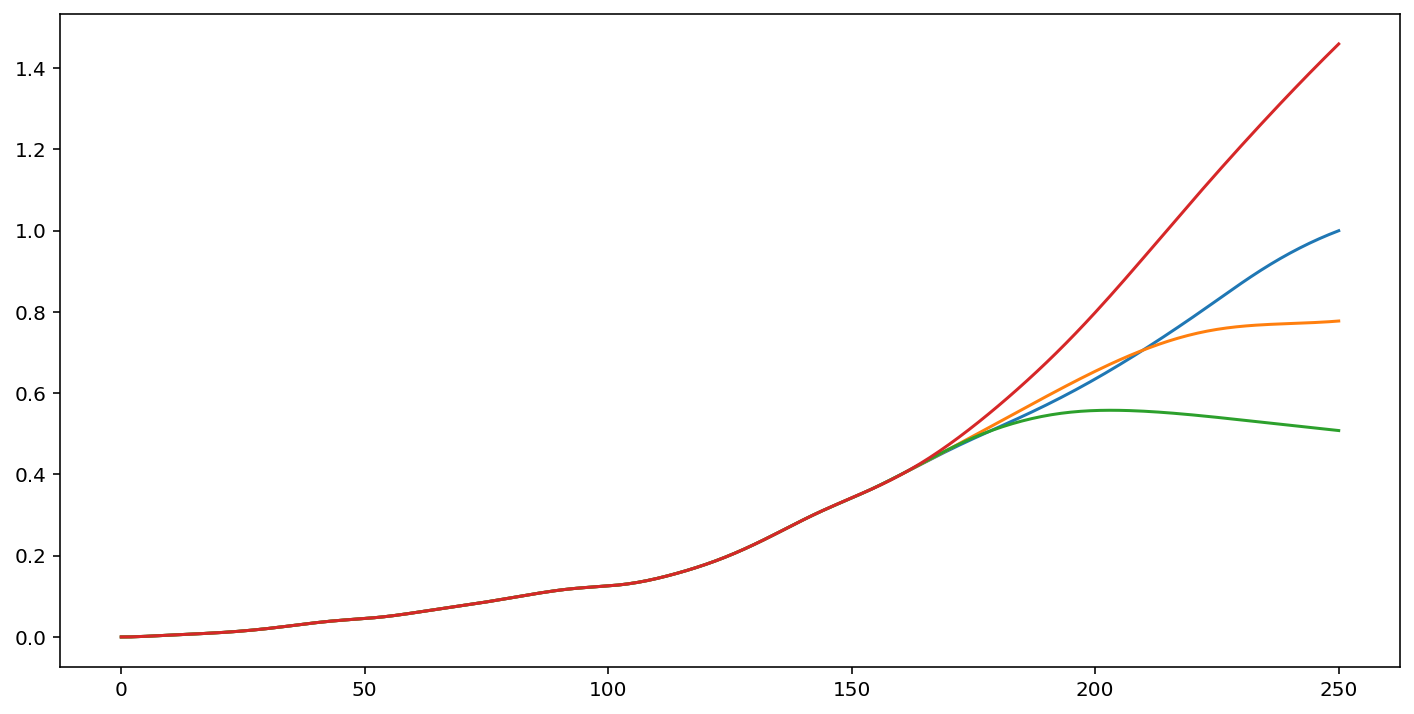

In [0]:
plt.plot(xnew)

In [0]:
np.ndarray.view(xnew)
#xnew.shape

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.07591198e-04, 2.07591199e-04, 2.07591198e-04, 2.07591200e-04],
       ...,
       [9.90441430e-01, 7.75905240e-01, 5.10623737e-01, 1.43602300e+00],
       [9.95279537e-01, 7.76735606e-01, 5.09327481e-01, 1.44790180e+00],
       [9.99929918e-01, 7.77666003e-01, 5.08029214e-01, 1.45969412e+00]])

## Convert the CO2 arrays of all the RCPs into a long dataframe

In [0]:
df_xcalc = pd.DataFrame(xnew, columns=['RCP60', 'RCP45', 'RCP26', 'RCP85'], index=np.linspace(1850, 2100, 251))
print(df_xcalc)

           RCP60     RCP45     RCP26     RCP85
1850.0  0.000000  0.000000  0.000000  0.000000
1851.0  0.000000  0.000000  0.000000  0.000000
1852.0  0.000208  0.000208  0.000208  0.000208
1853.0  0.000563  0.000563  0.000563  0.000563
1854.0  0.001020  0.001020  0.001020  0.001020
...          ...       ...       ...       ...
2096.0  0.980196  0.774498  0.513213  1.412012
2097.0  0.985414  0.775163  0.511919  1.424059
2098.0  0.990441  0.775905  0.510624  1.436023
2099.0  0.995280  0.776736  0.509327  1.447902
2100.0  0.999930  0.777666  0.508029  1.459694

[251 rows x 4 columns]


In [0]:
df_xcalc.reset_index()

,index,RCP60,RCP45,RCP26,RCP85
0,1850.0,0.000000,0.000000,0.000000,0.000000
1,1851.0,0.000000,0.000000,0.000000,0.000000
2,1852.0,0.000208,0.000208,0.000208,0.000208
3,1853.0,0.000563,0.000563,0.000563,0.000563
4,1854.0,0.001020,0.001020,0.001020,0.001020
...,...,...,...,...,...
246,2096.0,0.980196,0.774498,0.513213,1.412012
247,2097.0,0.985414,0.775163,0.511919,1.424059
248,2098.0,0.990441,0.775905,0.510624,1.436023
249,2099.0,0.995280,0.776736,0.509327,1.447902


## CO2 dataset - Wide to Long

In [0]:
df_xlong = df_xcalc.unstack().reset_index() 
print(df_xlong.head(10)) 


  level_0  level_1         0
0   RCP60   1850.0  0.000000
1   RCP60   1851.0  0.000000
2   RCP60   1852.0  0.000208
3   RCP60   1853.0  0.000563
4   RCP60   1854.0  0.001020
5   RCP60   1855.0  0.001543
6   RCP60   1856.0  0.002108
7   RCP60   1857.0  0.002694
8   RCP60   1858.0  0.003289
9   RCP60   1859.0  0.003885


## Format the long CO2 dataframe

In [0]:
df_xlong.columns = ['rcp','year','calCO2']
df_xlong['year'] = df_xlong['year'].astype(int)
df_xlong['ssp'] = df_xlong['rcp']

In [0]:
df_xlong["ssp"]= df_xlong["ssp"].str.replace("RCP26", "ssp126", case = False)
df_xlong["ssp"]= df_xlong["ssp"].str.replace("RCP45", "ssp245", case = False)
df_xlong["ssp"]= df_xlong["ssp"].str.replace("RCP85", "ssp585", case = False)

In [0]:
print(df_xlong)

        rcp  year    calCO2     ssp
0     RCP60  1850  0.000000   RCP60
1     RCP60  1851  0.000000   RCP60
2     RCP60  1852  0.000208   RCP60
3     RCP60  1853  0.000563   RCP60
4     RCP60  1854  0.001020   RCP60
...     ...   ...       ...     ...
999   RCP85  2096  1.412012  ssp585
1000  RCP85  2097  1.424059  ssp585
1001  RCP85  2098  1.436023  ssp585
1002  RCP85  2099  1.447902  ssp585
1003  RCP85  2100  1.459694  ssp585

[1004 rows x 4 columns]


## Merge Temp and Calculated CO2 dataframes

In [0]:
df_temp = pd.read_csv('/content/drive/Shared drives/GEOS39650/climate_emulator/data/12_CMIP6_models_global_mean.csv', sep=',')
df_merged = pd.merge(df_xlong, df_temp, on=['year', 'ssp'], how='outer')
print(df_merged)

         rcp  year    calCO2     ssp         model    mean_tas
0      RCP60  1850  0.000000   RCP60           NaN         NaN
1      RCP60  1851  0.000000   RCP60           NaN         NaN
2      RCP60  1852  0.000208   RCP60           NaN         NaN
3      RCP60  1853  0.000563   RCP60           NaN         NaN
4      RCP60  1854  0.001020   RCP60           NaN         NaN
...      ...   ...       ...     ...           ...         ...
13499    NaN  2099       NaN  ssp119     GFDL-ESM4  226.345520
13500    NaN  2099       NaN  ssp119  IPSL-CM6A-LR  287.663483
13501    NaN  2099       NaN  ssp119    MIROC-ES2L  289.358185
13502    NaN  2099       NaN  ssp119        MIROC6  289.335358
13503    NaN  2099       NaN  ssp119    MRI-ESM2-0  288.154694

[13504 rows x 6 columns]


In [0]:
df_merged.to_csv('/content/drive/Shared drives/GEOS39650/climate_emulator/data/12_CMIP6_models_temperature_merged.csv', sep=',', index=False)

In [0]:
innerdf = pd.merge(df_xlong, df_temp, on=['year', 'ssp'], how='inner')
traindf = innerdf[innerdf.ssp != 'ssp545']
xval = traindf['calCO2'].values
yval = traindf['mean_tas'].values

In [0]:
xval = np.array(xval)
xval = xval.reshape(xval.shape[0], 1)


In [0]:
xval.shape

(8750, 1)

In [0]:
yval.shape

(8750,)

In [0]:
m = LinearRegression(normalize = False, fit_intercept = True )
fitted = m.fit(xval, yval)
beta1 = fitted.coef_
beta0 = fitted.intercept_

In [0]:
beta1

array([2.77695204])

In [0]:
beta0

265.3389308243265

In [0]:
x45 = df[df.ssp == 'ssp545']

In [0]:
test = fitted.predict(X45)

In [0]:
plt.plot(test)
plt.plot(df.temperture) #origional value)

## Regression #2

In [0]:
# load temperature data
df = pd.read_csv('/content/drive/Shared drives/GEOS39650/climate_emulator/data/12_CMIP6_models_global_mean.csv', sep=',')
df2 = df[df.model == 'MRI-ESM2-0'] #filter for a model
df2 = df2[df2.ssp == 'ssp585']     #filter an RCP
df2.mean_tas

13000    286.940216
13001    286.991943
13002    286.911530
13003    286.806549
13004    286.767242
            ...    
13245    291.359009
13246    291.552704
13247    291.771454
13248    291.462769
13249    291.568451
Name: mean_tas, Length: 250, dtype: float64



---



---



---



---



## For CMIP-5 data on google cloud

In [0]:
# Load array of avaible models
df = pd.read_csv('https://storage.googleapis.com/cmip6/pangeo-cmip5.csv')
df_tas = df.query("activity_id=='CMIP5' & table_id == 'Amon' & variable_id == 'tas'")
models = df_tas.source_id.unique()
models


## To search for CMIP-5 or CMIP-6 data on ESGF (for

In [0]:
conn = SearchConnection('http://esgf-index1.ceda.ac.uk/esg-search', distrib=True)

In [0]:
ctx = conn.new_context(
    project='CMIP5',
    experiment='rcp45',
    model='HadCM3',
    ensemble='r1i1p1',
    time_frequency='mon',
    realm='atmos',
    data_node='esgf-data1.ceda.ac.uk',
    )
ctx.hit_count

result = ctx.search()[0]
files = result.file_context().search()

In [0]:
ds = xr.open_dataset(tasmax_url, chunks={'time': 120})
ds

In [0]:
ctx = conn.new_context(
    project = 'CMIP6',
    experiment_id = 'ssp585',
    variable = 'tas',
    frequency = 'mon',
    data_node='esgf-data3.ceda.ac.uk')

result = ctx.search()[0]
files = result.file_context().search()
for file in files:
    print(file.opendap_url)

In [0]:
ctx = conn.new_context(
    project='CMIP6',
    experiment_id='ssp585',
    variable='tas',
    frequency='mon')

result = ctx.search()

In [0]:
ds = xr.open_dataset(files[0].opendap_url, chunks={'time': 120})
ds

In [0]:
#GEOMIP data

ctx = conn.new_context(
    experiment='G4cdnc',
    realm='atmos',
    data_node='esgf-data1.ceda.ac.uk',
    )
ctx.hit_count
result = ctx.search()[0]
files = result.file_context().search()
ds = xr.open_dataset(files[0].opendap_url, chunks={'time': 120})
ds

In [0]:
'''
# OLD CODES

# Load array of available models that do RCP 8.5 and have an area file (to calc temperature)
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_mod = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'ssp585'")
models = df_mod.source_id.unique()
models = list(models)
df_area = df.query("variable_id == 'areacella'")
areas = df_area.source_id.unique()
areas = list(areas)
models = set(models) & set(areas)
# remove this 'MAC' model because it has bad longitude and latitude values
models = ['CESM2','CESM2-WACCM','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','MIROC-ES2L','MIROC6','MPI-ESM1-2-HR','MRI-ESM2-0']

'''

## Model Lists by variable_id 'ts', 'tas', and SSPs

### FOR SSP 585 (=RCP 8.5)
#### TAS FULL LIST - 
['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 
'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM',
'CESM2', 'KACE-1-0-G', 'GFDL-CM4', 'GFDL-ESM4', 'MCM-UA-1-0']

#### TS FULL LIST - 
['AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2',
'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'UKESM1-0-LL',
'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'NorESM2-LM', 'KACE-1-0-G', 'GFDL-CM4', 'GFDL-ESM4', 'NESM3', 'MCM-UA-1-0']

#### Did Not Work for tas - 
['CNRM-CM6-1-HR','INM-CM5-0', 'MCM-UA-1-0']
#### Did Not Work for ts - 
['AWI-CM-1-1-MR', 'CNRM-CM6-1-HR', 'MCM-UA-1-0']
#### WORKS FOR BOTH - 
['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5',
'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'KACE-1-0-G', 'GFDL-CM4', 
'GFDL-ESM4']

## FOR SSP 245 (=RCP 4.5)
### TAS FULL LIST - 
['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'FIO-ESM-2-0',
 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'GFDL-CM4', 'GFDL-ESM4', 'MCM-UA-1-0']

### TS FULL LIST - 
['AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR',
 'EC-Earth3-Veg', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'CESM2-WACCM',
 'CESM2', 'NorESM2-LM', 'GFDL-CM4', 'GFDL-ESM4', 'NESM3', 'MCM-UA-1-0']

#### Did Not Work for tas - 
['MCM-UA-1-0']
#### Did Not Work for ts - 
['AWI-CM-1-1-MR', 'MCM-UA-1-0']
#### WORKS FOR BOTH - 
['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR',
'EC-Earth3-Veg', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'GFDL-CM4', 'GFDL-ESM4']


## FOR SSP 126 (=RCP 2.6)
### TAS FULL LIST - 
['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR',
 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM',
 'CESM2', 'KACE-1-0-G', 'GFDL-ESM4', 'NESM3', 'MCM-UA-1-0']

### TS FULL LIST - 
['AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR',
 'EC-Earth3-Veg', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'CESM2-WACCM',
 'CESM2', 'NorESM2-LM', 'NorESM2-MM', 'KACE-1-0-G', 'GFDL-ESM4', 'NESM3', 'MCM-UA-1-0']

#### Did Not Work for tas - 
['INM-CM4-8', 'INM-CM5-0', 'MCM-UA-1-0']
#### Did Not Work for ts - 
['AWI-CM-1-1-MR','MCM-UA-1-0']
#### WORKS FOR BOTH - 
['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR',
 'EC-Earth3-Veg', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'KACE-1-0-G', 'GFDL-ESM4', 'NESM3']